# Fuzzy Logic for Python 3

The doctests in the modules should give a good idea how to use things by themselves, while here are some examples how to use everything together.

### Functions and Sets
Defining a domain with its range and resolution should be trivial since most real world instruments come with those specifications. However, defining the fuzzy sets within those domains is where the fun begins as only a human can tell whether something is "hot" or "not", right?
I've included some simple convenience functions that combine two or more functions over a range, however I consciously left out more complex "convenience" functions such as polygons because it is probably easier to just build those as combinations of sets.

Why the distinction? Functions only map values, nothing special there at all - which is good for testing and performance. Sets on the other hand implement logical operations that have special python syntax, which makes it easy to work with but a little more difficult to test and adds some performance overhead. So, sets are for abstraction and easy handling, functions for performance.

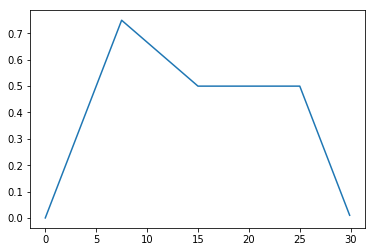

In [1]:
%matplotlib inline
from fuzzy.classes import Domain, Set
from fuzzy.functions import R, S, alpha

T = Domain("test", 0, 30, res=0.1)

up = Set(R(0,10))
top = Set(alpha(0.5, 1, S(0, 30)))
down = Set(S(20, 30))
T.polygon = up & top & down

T.polygon.plot()
#T.not_polygon = ~T.polygon
#T.not_polygon.plot()

### Domains

After specifying the domain and assigning sets, calling a domain with a value returns a dict of memberships of the sets in that domain.

{'bar': 0.6400000000000001,
 'baz': 0.8359591794226543,
 'foo': 0.5443310539518174}

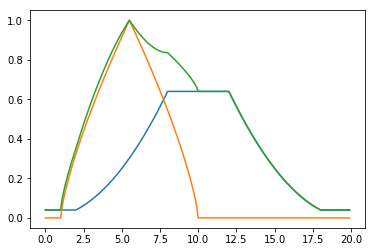

In [2]:
%matplotlib inline

from fuzzy.classes import Domain, Set
from fuzzy.functions import alpha, triangular
from fuzzy.hedges import plus, minus, very

numbers = Domain("numbers", 0, 20, res=0.1)

close_to_10 = Set(alpha(0.2, 0.8, triangular(0, 20)))
close_to_5 = Set(triangular(1,10))

numbers.foo = minus(close_to_5)
numbers.bar = very(close_to_10)

numbers.bar.plot()
numbers.foo.plot()
numbers.baz = numbers.foo + numbers.bar
numbers.baz.plot()

numbers(8)

### Inference

After measuring a RL value and mapping it to sets within a domain, it is normally needed to translate the result to another domain that corresponds to some sort of control mechanism. This translation or mapping is called inference and is rooted in the logical conclusion operation A => B, for example: If it rains then the street is wet.
The street may be wet for a number of reasons, but if it rains it will be wet for sure. This **IF A THEN B** can also be written as
***(A AND B) OR NOT(A AND TRUE)***. This may look straight forward for boolean logic, but since we are not just dealing with True and False, there are a number of ways in fuzzy logic to actually implement this.

In [29]:
%matplotlib inline

from fuzzy.classes import Domain, Set, Rule
from fuzzy.functions import alpha, triangular, gauss, R, S
import fuzzy.functions as fun
from fuzzy.hedges import plus, minus, very

IN = Domain("numbers in", 0, 10, res=0.1)
IN.close_5 = Set(triangular(2, 10, c=5))
OUT = Domain("numbers out", 100, 200)

D = Domain("d", 0, 10, res=0.1)
D.s1 = Set(fun.bounded_linear(3, 12))
D.s2 = ~~D.s1
all(isclose(D.s1.array(), D.s2.array()))

False

In [4]:
from numpy import outer

from fuzzy.classes import Domain, Set, Rule
from fuzzy.functions import triangular

form = Domain("form", 1, 4.1, res=1)
medium_form = Set(form, triangular(1, 4, p=3))
medium_form.plot()

diff = Domain("difficulty", 1, 5.1, res=1)
medium_difficulty = Set(diff, triangular(1,5, p=3))
medium_difficulty.plot()

# this should be
# max(min(m_a(x), m_b(x)), 1-m_a(x)) for every elem
outer([0, 0.6, 1, 0.2], [0, 0.4, 1, 0.8, 0.3, 0])


fromiter

TypeError: triangular() got an unexpected keyword argument 'p'

In [ ]:
%matplotlib inline

from fuzzy.classes import Domain, Set
from fuzzy.functions import alpha, triangular
from fuzzy.hedges import plus, minus, very

numbers = Domain("numbers", 0, 20, res=0.1)

close_to_10 = Set(alpha(0.2, 0.8, triangular(0, 20)))
close_to_5 = Set(triangular(1,10))

numbers.foo = minus(close_to_5)
numbers.bar = very(close_to_10)

numbers.bar.plot()
numbers.foo.plot()
numbers.baz = numbers.foo + numbers.bar
numbers.baz.plot()

numbers(8)

30

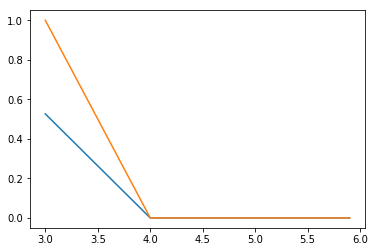

In [7]:
%matplotlib inline

from fuzzy.classes import Domain, Set
from fuzzy.functions import alpha, triangular, trapezoid, normalize
from fuzzy.hedges import plus, minus, very

N = Domain("numbers", 3, 6, res=0.1)
N.two_or_so = Set(alpha(0, 0.7, trapezoid(0, 1.9, 2.1, 4)))
N.two_or_so.plot()
x = N.two_or_so.normalized()
x.plot()
len(x.array())

## Sources
* Fuzzy Logic and Control: Software and Hardware Applications, Volume 2

      By: Mohammad Jamshidi; Nader Vadiee; Timothy J. Ross - University of New Mexico
      Publisher: Prentice Hall
      Pub. Date: June 07, 1993